<a href="https://colab.research.google.com/github/JericCantos/TIL/blob/master/data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Load Data

In [1]:
import pandas as pd
import requests
import io
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Build the direct download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))

# Dictionary of file IDs for clarity
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

# Load each CSV using the helper functions
df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
# df_train          = load_csv_from_url(make_drive_url(file_ids["train"])) we dont read it as the file is too big and wont work this way
df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))


## Loading df_train

filter only to stores in "Guayas"

In [5]:
!pip install -U gdown

In [6]:
import gdown

# Use our existing function to build the download URL
train_url = make_drive_url(file_ids["train"])

# Download the file using gdown
gdown.download(train_url, "train.csv", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=1f63ceb6-ec09-489d-8dae-46ce2389c255
To: /content/train.csv
100%|██████████| 5.00G/5.00G [01:09<00:00, 71.8MB/s]


'train.csv'

In [7]:
# select only stores in 'Guayas' state
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()


# read the imported. data in chunks
chunk_size = 10**6  # 1 million rows at a time
filtered_chunks = []

for chunk in pd.read_csv("train.csv", chunksize=chunk_size):
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    filtered_chunks.append(chunk_filtered)
    del chunk  # Free up memory

# combine all chunks into one dataframe
df_train = pd.concat(filtered_chunks, ignore_index=True)

# down-sample to 2 million rows
df_train = df_train.sample(n=2_000_000).reset_index(drop=True)

/tmp/ipython-input-7-946473318.py:9: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("train.csv", chunksize=chunk_size):


In [21]:
# free up memory
del filtered_chunks

### Filter by Product Family
- keep only the three biggest product families (measured by how many unique items each family contains)

In [8]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [12]:
df_items['family'].value_counts()
# top three families are: GROCERY I,  BEVERAGES, and CLEANING

,count
family,
GROCERY I,1334
BEVERAGES,613
CLEANING,446
PRODUCE,306
DAIRY,242
PERSONAL CARE,153
BREAD/BAKERY,134
HOME CARE,108
DELI,91


In [16]:
# join df_train with df_items then filter only top 3

top_3_families = ['GROCERY I',  'BEVERAGES', 'CLEANING']

df_train_family = pd.merge(
    df_train,
    df_items,
    on = 'item_nbr',
    how = 'inner'

    )

df_train_family.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable
0,29340652,2014-08-19,51,417835,1.000,False,GROCERY I,1028,0
1,1324310,2013-02-03,32,155500,18.000,NaN,GROCERY I,1014,0
2,88558245,2016-08-20,24,1239862,2.597,False,POULTRY,2420,1
3,111800519,2017-04-08,24,1986500,1.000,False,HOME CARE,3108,0
4,56649285,2015-09-15,28,527757,2.000,False,GROCERY I,1032,0


In [17]:
print ('original dataset length:', len(df_train),
       '\nwith families length:', len(df_train_family) )
df_train = df_train_family[df_train_family['family'].isin(top_3_families)]

print ('filtered top 3 length:', len(df_train))

original dataset length: 2000000 
with families length: 2000000
filtered top 3 length: 1284286


In [18]:
df_train['family'].unique()

array(['GROCERY I', 'BEVERAGES', 'CLEANING'], dtype=object)

### Save Pickle

In [20]:
# 1. Mount Drive (one-time click to authorize)
from google.colab import drive
drive.mount('/content/drive')

# 2. Pick a folder inside Drive (create it if it doesn’t exist)
save_path = "/content/drive/MyDrive/Masterschool_Time_Series/df_train_clean.pkl"


# 3. SAVE the cleaned DataFrame
df_train.to_pickle(save_path)
print(f"Saved to: {save_path}")



Mounted at /content/drive
Saved to: /content/drive/MyDrive/Masterschool_Time_Series/df_train_clean.pkl


### Load Pickle



In [3]:
# -----------------------------------------------
# Uncomment and Run this to reload dataframe
# -----------------------------------------------

'''
from google.colab import drive
drive.mount('/content/drive')              # re-mount
load_path = "/content/drive/MyDrive/Masterschool_Time_Series/df_train_clean.pkl" #example of path, use the same as above
df_train = pd.read_pickle(load_path)
print("DataFrame reloaded, ready to go!")
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DataFrame reloaded, ready to go!


# Data Cleaning

## Check for Missing Data

### df_train
Almost 240k rows with null onpromotioon exist. No other null values exist.

given that this is roughly 18% of the data, dropping the rows will not be a good option.
Question would be whether to drop the column, or impute it.

Based on the remainder of the dataset, more than 94% of the rows have onpromotion = False, so it seems better to replace nulls with False.

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1284286 entries, 0 to 1999999
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id           1284286 non-null  int64  
 1   date         1284286 non-null  object 
 2   store_nbr    1284286 non-null  int64  
 3   item_nbr     1284286 non-null  int64  
 4   unit_sales   1284286 non-null  float64
 5   onpromotion  1044632 non-null  object 
 6   family       1284286 non-null  object 
 7   class        1284286 non-null  int64  
 8   perishable   1284286 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 98.0+ MB


In [5]:
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,239654
family,0
class,0
perishable,0


In [6]:
df_train['onpromotion'].value_counts(normalize=True)

,proportion
onpromotion,
False,0.94351
True,0.05649


In [7]:
df_train.loc[:,'onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

df_train.isnull().sum()

/tmp/ipython-input-7-3922442648.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train.loc[:,'onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0
family,0
class,0
perishable,0


### df_oil
- 43 nulls for the dcoilwtico column.
- dropping this does not seem to be a good idea since this seems to be a time series too, and each date is unique.
- for now, I will try linear interpolation to fill the nulls.
- since the very first row has a null value, I will just backward fill it.

In [8]:
df_oil.isnull().sum()

,0
date,0
dcoilwtico,43


In [9]:
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate(method='linear')
df_oil.isnull().sum()

,0
date,0
dcoilwtico,1


In [10]:
#backward fill the first row
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].bfill()
df_oil.isnull().sum()

,0
date,0
dcoilwtico,0


In [11]:
df_oil.iloc[:2, :]

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14


### df_items, df_holiday_events, df_stores, df_transactions
No nulls

In [12]:
df_items.isnull().sum()

,0
item_nbr,0
family,0
class,0
perishable,0


In [13]:
df_holiday_events.isnull().sum()

,0
date,0
type,0
locale,0
locale_name,0
description,0
transferred,0


In [14]:
df_stores.isnull().sum()

,0
store_nbr,0
city,0
state,0
type,0
cluster,0


In [15]:
df_transactions.isnull().sum()

,0
date,0
store_nbr,0
transactions,0


## Check for Outliers

### Treat product returns as no sale

In [16]:
#replace all negative unit_sales with 0
df_train.loc[:,'unit_sales'] = df_train['unit_sales'].apply(
                        lambda x: 0 if x<0 else x)

df_train.describe()

,id,store_nbr,item_nbr,unit_sales,class,perishable
count,1.284286e+06,1.284286e+06,1.284286e+06,1.284286e+06,1.284286e+06,1284286.0
mean,6.149199e+07,3.245629e+01,9.037291e+05,6.818343e+00,1.479756e+03,0.0
std,3.638971e+07,7.846689e+00,5.232732e+05,1.898832e+01,7.998918e+02,0.0
min,1.880500e+04,2.400000e+01,9.699500e+04,0.000000e+00,1.002000e+03,0.0
25%,2.979652e+07,2.700000e+01,4.280540e+05,2.000000e+00,1.034000e+03,0.0
50%,6.087684e+07,3.000000e+01,8.902130e+05,3.000000e+00,1.074000e+03,0.0
75%,9.297850e+07,3.500000e+01,1.213906e+06,7.000000e+00,1.144000e+03,0.0
max,1.254915e+08,5.100000e+01,2.127114e+06,1.043700e+04,3.090000e+03,0.0


### Identify outliers

only around 26% of our outliers are correlated with either promotions or holidays

In [17]:
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score for unit_sales
    # (avoiding division by zero for standard deviation),
    # and store it in a new column called z_score
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales
                                                             if std_sales != 0
                                                             else 1)
    return group

In [18]:
# Apply the Z-score calculation to each store-item group, then flatten the index
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr'])\
                            .apply(calculate_store_item_zscore,
                                   include_groups=True)
df_train_grouped.reset_index(drop=True, inplace=True)

# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

# Print summary
print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

Number of outliers detected: 3578


/tmp/ipython-input-18-3151766863.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_store_item_zscore,


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,z_score
184,76849626,2016-04-20,24,105574,110.0,False,GROCERY I,1045,0,8.577076
285,10380405,2013-08-29,24,105575,50.0,False,GROCERY I,1045,0,6.696045
732,37868850,2014-12-21,24,105857,57.0,False,GROCERY I,1092,0,7.065538
1081,76655460,2016-04-18,24,108786,16.0,False,CLEANING,3044,0,5.237162
1645,72156861,2016-03-02,24,111397,55.0,False,GROCERY I,1072,0,5.384900


In [19]:
# check whether outliers are correlated with holidays or promotions

#merge outliers with holidays
outliers_copy = pd.merge(outliers, df_holiday_events, how='left', on='date')

# check what the union of holidays and promotions are
on_promotion_or_holiday = len(outliers_copy[(outliers_copy['onpromotion']==True)
                              | (~outliers_copy['type'].isnull()) ])

not_promotion_nor_holiday = len(outliers_copy[(outliers_copy['onpromotion']==False)
                              & (outliers_copy['type'].isnull()) ])

total = len(outliers_copy)

print('Total Outliers:', total,
      '\n On Promotion or Holiday:', on_promotion_or_holiday,
      '\n Not on Promotion nor Holiday', not_promotion_nor_holiday,
      '\n % on Promotion nor Holiday', on_promotion_or_holiday*100/total)

Total Outliers: 3708 
 On Promotion or Holiday: 1982 
 Not on Promotion nor Holiday 1726 
 % on Promotion nor Holiday 53.45199568500539


In [20]:
outliers_copy['unit_sales'].describe()

,unit_sales
count,3708.000000
mean,73.851672
std,250.948696
min,4.000000
25%,19.000000
50%,32.500000
75%,65.000000
max,10437.000000


/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


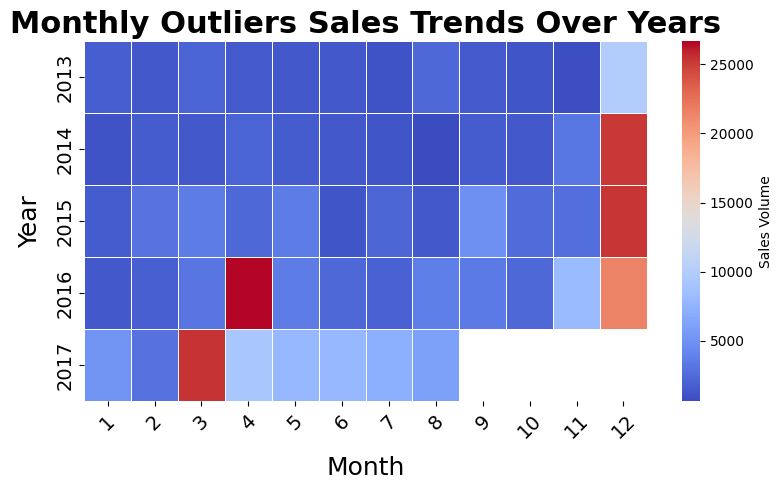

In [21]:
outliers_copy.loc[:, 'date'] = pd.to_datetime(outliers_copy['date'])
outliers_copy = outliers_copy.set_index('date').sort_index()
outliers_copy.reset_index(inplace=True, drop=False)


# Split the timestamp
outliers_copy['year'] = outliers_copy['date'].dt.year
outliers_copy['month'] = outliers_copy['date'].dt.month
outliers_copy['day'] = outliers_copy['date'].dt.day
outliers_copy['week'] = outliers_copy['date'].dt.isocalendar().week
outliers_copy['day_of_week'] = outliers_copy['date'].dt.day_of_week

# group by month and year, see if there's a trend to when the outliers occur
outliers_by_month = (
    outliers_copy.groupby(['year', 'month'])['unit_sales'].sum().unstack()
)

import seaborn as sns

plt.figure(figsize=(8,5))
sns.heatmap(
   outliers_by_month,
   cmap='coolwarm',
   linewidths=0.5,
   linecolor='white',
   cbar_kws={'label': 'Sales Volume'}
)

# Customizing title and axes labels
plt.title('Monthly Outliers Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)
plt.ylabel('Year', fontsize=18, labelpad=10)
# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
# Adjust layout for better spacing
plt.tight_layout()
# Display the heatmap
plt.show()

inconclusive by month, maybe by calendar week?

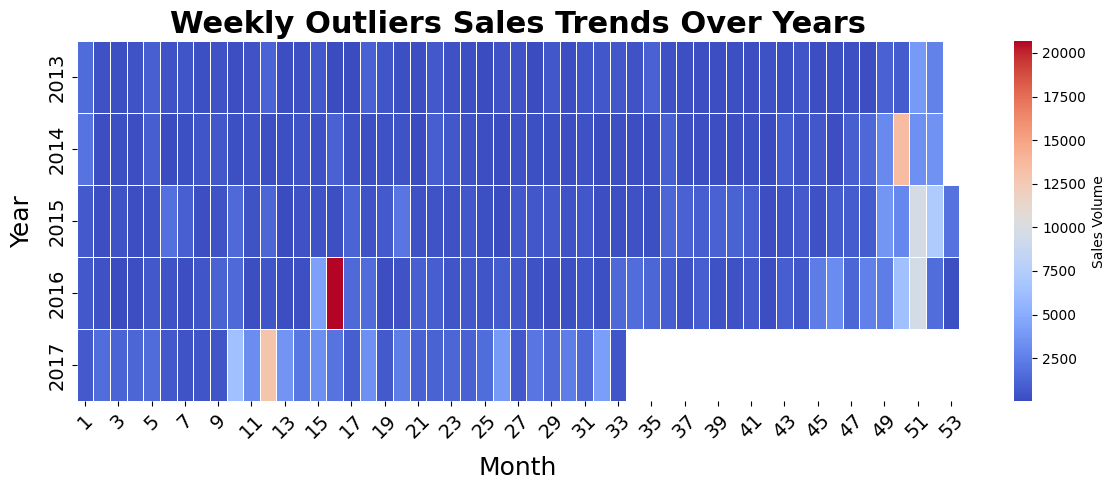

In [22]:
# group by week and year, see if there's a trend to when the outliers occur
outliers_by_week = (
    outliers_copy.groupby(['year', 'week'])['unit_sales'].sum().unstack()
)


plt.figure(figsize=(12,5))
sns.heatmap(
   outliers_by_week,
   cmap='coolwarm',
   linewidths=0.5,
   linecolor='white',
   cbar_kws={'label': 'Sales Volume'}
)

# Customizing title and axes labels
plt.title('Weekly Outliers Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)
plt.ylabel('Year', fontsize=18, labelpad=10)
# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
# Adjust layout for better spacing
plt.tight_layout()
# Display the heatmap
plt.show()

In [23]:
outliers_copy['day_of_week'].value_counts()

,count
day_of_week,
6,648
0,557
5,556
1,546
2,497
3,459
4,445


Still can't find a trend. Random spot checks show that the outliers happen all over the calendar i.e. not necessarily only during summer or holiday periods. Most outliers seem to occur on Sundays and Mondays, but the counts are not too far away from the rest of the days.


Right now I don't know whether to remove these outliers or re-scale. To preserve as much data as possible, I will just label the outliers in the training dataset.

In [24]:
df_train['outlier'] = df_train['id'].isin(outliers['id'])
df_train['outlier'].value_counts()

,count
outlier,
False,1280708
True,3578


## Fill Missing Dates with Zero Sales

In [25]:
# Turn the date column into real dates

df_train.loc['date'] = pd.to_datetime(df_train['date'])

In [26]:
# define a function to create a full daily calendar
# for every store-item pair
# expect df_train.groupby(['store_nbr', 'item_nbr'])

def fill_calendar(group):
  #
  # group contains all rows for ONE (store_nbr, item_nbr) pair
  #
  g = group.set_index("date").sort_index()   # use date/calendar as the index

  g = g.asfreq("D", fill_value=0)
  # make it daily; add 0 to all columns where the date is missing

	# put the identifiers back (asfreq drops them)
  g.loc[:,"store_nbr"] = group["store_nbr"].iloc[0]
  g.loc[:,"item_nbr"] = group["item_nbr"].iloc[0]

  g = g.infer_objects()  # force consistent datatype to suppress warning
  return g.reset_index() # date back to a normal column

In [27]:
# Apply the function to every store-item pair
df_train = (
    df_train
    .groupby(["store_nbr", "item_nbr"], group_keys=False)  # keeps memory low
    .apply(fill_calendar)
)

df_train.head(25)

/tmp/ipython-input-27-2293031412.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_calendar)


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,outlier
0,2013-01-17,0,24,96995,0,0,0,0,0,0
1,2013-01-18,0,24,96995,0,0,0,0,0,0
2,2013-01-19,0,24,96995,0,0,0,0,0,0
3,2013-01-20,0,24,96995,0,0,0,0,0,0
4,2013-01-21,0,24,96995,0,0,0,0,0,0
5,2013-01-22,0,24,96995,0,0,0,0,0,0
6,2013-01-23,0,24,96995,0,0,0,0,0,0
7,2013-01-24,0,24,96995,0,0,0,0,0,0
8,2013-01-25,0,24,96995,0,0,0,0,0,0
9,2013-01-26,0,24,96995,0,0,0,0,0,0


## Feature Engineering

In [28]:
# onpromotion, outlier, perishable to type bool
# rename outlier to is_outlier
df_train.rename(columns={'outlier': 'is_outlier'}, inplace=True)

df_train.loc[:,'onpromotion'] = df_train['onpromotion'].astype(bool)
df_train.loc[:,'is_outlier'] = df_train['is_outlier'].astype(bool)
df_train.loc[:,'perishable'] = df_train['perishable'].astype(bool)
df_train.head()

/tmp/ipython-input-28-3589863621.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[:,'onpromotion'] = df_train['onpromotion'].astype(bool)
/tmp/ipython-input-28-3589863621.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[:,'is_outlier'] = df_train['is_outlier'].astype(bool)
/tmp/ipython-input-28-3589863621.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,is_outlier
0,2013-01-17,0,24,96995,0,False,0,0,False,False
1,2013-01-18,0,24,96995,0,False,0,0,False,False
2,2013-01-19,0,24,96995,0,False,0,0,False,False
3,2013-01-20,0,24,96995,0,False,0,0,False,False
4,2013-01-21,0,24,96995,0,False,0,0,False,False


In [29]:
# merge with holiday calendar to see if sale happened during holiday
# and what type of holiday it is

# convert df_holiday_events date to datetime
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])

df_train = pd.merge(df_train, df_holiday_events, on='date', how='left')
df_train.head()


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,is_outlier,type,locale,locale_name,description,transferred
0,2013-01-17,0,24,96995,0,False,0,0,False,False,NaN,NaN,NaN,NaN,NaN
1,2013-01-18,0,24,96995,0,False,0,0,False,False,NaN,NaN,NaN,NaN,NaN
2,2013-01-19,0,24,96995,0,False,0,0,False,False,NaN,NaN,NaN,NaN,NaN
3,2013-01-20,0,24,96995,0,False,0,0,False,False,NaN,NaN,NaN,NaN,NaN
4,2013-01-21,0,24,96995,0,False,0,0,False,False,NaN,NaN,NaN,NaN,NaN


In [33]:
df_train.transferred.unique()

array([nan, False, True], dtype=object)

In [ ]:
# fill the nulls from holidays

df_train['type'] = df_train['type'].fillna('Not a Holiday')
df_train['locale'] = df_train['locale'].fillna('Not a Holiday')
df_train['locale_name'] = df_train['locale_name'].fillna('Not a Holiday')
df_train['description'] = df_train['description'].fillna('Not a Holiday')
df_train['transferred'] = df_train['transferred'].fillna(False)

df_train.isnull().sum()